# Common ML Algorithms for Fraud Detection



- Logistic Regression
- Random Forest
- XGBoost
- Isolation Forest (for anomaly detection)
- Neural Networks

In [2]:
!pip install kafka-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.5/308.5 kB 16.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import time
from kafka import KafkaConsumer
import json
import threading
import pickle
from datetime import datetime

In [4]:
class FraudDetectionRealTime:
    def __init__(self, model_type='random_forest'):
        """
        Initialize the fraud detection system

        Args:
            model_type (str): Type of model to use - 'random_forest', 'xgboost',
                             'logistic_regression', or 'isolation_forest'
        """
        self.model_type = model_type
        self.model = None
        self.scaler = StandardScaler()
        self.feature_columns = None
        self.threshold = 0.7  # Default threshold for fraud detection

    def train_model(self, X_train, y_train):
        """Train the selected model on the provided data"""
        print(f"Training {self.model_type} model...")
        start_time = time.time()

        if self.model_type == 'random_forest':
            self.model = RandomForestClassifier(
                n_estimators=100,
                max_depth=10,
                class_weight='balanced',
                random_state=42,
                n_jobs=-1
            )
        elif self.model_type == 'xgboost':
            self.model = xgb.XGBClassifier(
                n_estimators=100,
                max_depth=5,
                learning_rate=0.1,
                scale_pos_weight=sum(y_train==0)/sum(y_train==1),  # Handle class imbalance
                random_state=42,
                n_jobs=-1
            )
        elif self.model_type == 'logistic_regression':
            self.model = LogisticRegression(
                C=0.1,
                class_weight='balanced',
                random_state=42,
                max_iter=1000
            )
        elif self.model_type == 'isolation_forest':
            self.model = IsolationForest(
                n_estimators=100,
                contamination=float(sum(y_train)/len(y_train)),  # Set contamination to fraud rate
                random_state=42,
                n_jobs=-1
            )

        # Train the model
        self.model.fit(X_train, y_train)

        print(f"Model trained in {time.time() - start_time:.2f} seconds")
        return self.model

    def evaluate_model(self, X_test, y_test):
        """Evaluate the model performance on test data"""
        # Make predictions
        if self.model_type == 'isolation_forest':
            # Convert outlier scores to binary predictions (-1 for outliers, 1 for inliers)
            y_pred = np.where(self.model.predict(X_test) == -1, 1, 0)
        else:
            y_pred = self.model.predict(X_test)

        # Get detailed metrics
        print("\nModel Evaluation:")
        conf_matrix = confusion_matrix(y_test, y_pred)
        print(conf_matrix)

        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Plot ROC curve
        if hasattr(self.model, "predict_proba") and self.model_type != 'isolation_forest':
            y_score = self.model.predict_proba(X_test)[:, 1]
            self._plot_roc_curve(y_test, y_score)

        return conf_matrix, y_pred

    def _plot_roc_curve(self, y_true, y_score):
        """Plot ROC curve and calculate AUC"""
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

    def predict_probability(self, transaction):
        """
        Get fraud probability for a transaction

        Args:
            transaction: DataFrame or dict containing transaction data

        Returns:
            float: Probability of fraud (0 to 1)
        """
        if isinstance(transaction, dict):
            transaction = pd.DataFrame([transaction])

        # Scale features
        scaled_transaction = self.scaler.transform(transaction[self.feature_columns])

        # Get prediction
        if self.model_type == 'isolation_forest':
            # For Isolation Forest, convert decision function to probability-like score
            score = self.model.decision_function(scaled_transaction)[0]
            # Lower scores indicate higher anomaly, so we invert
            return 1 - (1 / (1 + np.exp(-score)))
        else:
            # For classifiers that support probability estimates
            return self.model.predict_proba(scaled_transaction)[:, 1][0]

    def save_model(self, filename):
        """Save the trained model and scaler to disk"""
        model_data = {
            'model': self.model,
            'scaler': self.scaler,
            'feature_columns': self.feature_columns,
            'model_type': self.model_type,
            'threshold': self.threshold
        }
        with open(filename, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"Model saved to {filename}")

    def load_model(self, filename):
        """Load a previously trained model from disk"""
        with open(filename, 'rb') as f:
            model_data = pickle.load(f)

        self.model = model_data['model']
        self.scaler = model_data['scaler']
        self.feature_columns = model_data['feature_columns']
        self.model_type = model_data['model_type']
        self.threshold = model_data.get('threshold', 0.7)

        print(f"Model loaded from {filename}")
        return self.model

In [5]:
class RealTimeTransactionProcessor:
    def __init__(self, fraud_detector, kafka_settings=None):
        """
        Initialize the real-time transaction processor

        Args:
            fraud_detector: Trained FraudDetectionRealTime instance
            kafka_settings: Dictionary with Kafka settings (bootstrap_servers, topic)
        """
        self.fraud_detector = fraud_detector
        self.kafka_settings = kafka_settings or {
            'bootstrap_servers': 'localhost:9092',
            'topic': 'transactions'
        }
        self.consumer = None
        self.running = False
        self.alert_threshold = 0.7
        self.transaction_count = 0
        self.fraud_count = 0

    def connect_to_kafka(self):
        """Connect to Kafka stream"""
        try:
            self.consumer = KafkaConsumer(
                self.kafka_settings['topic'],
                bootstrap_servers=self.kafka_settings['bootstrap_servers'],
                auto_offset_reset='latest',
                enable_auto_commit=True,
                group_id='fraud_detection_group',
                value_deserializer=lambda x: json.loads(x.decode('utf-8'))
            )
            print(f"Connected to Kafka topic: {self.kafka_settings['topic']}")
            return True
        except Exception as e:
            print(f"Failed to connect to Kafka: {e}")
            return False

    def process_transaction(self, transaction):
        """Process a single transaction and check for fraud"""
        # Extract features
        if not all(col in transaction for col in self.fraud_detector.feature_columns):
            print(f"Warning: Transaction missing required features")
            return None

        # Create DataFrame with only the needed features
        transaction_df = pd.DataFrame([{col: transaction.get(col, 0)
                                      for col in self.fraud_detector.feature_columns}])

        # Get fraud probability
        fraud_probability = self.fraud_detector.predict_probability(transaction_df)

        # Determine if transaction is fraudulent
        is_fraud = fraud_probability > self.alert_threshold

        # Track statistics
        self.transaction_count += 1
        if is_fraud:
            self.fraud_count += 1

        result = {
            'transaction_id': transaction.get('transaction_id', 'unknown'),
            'timestamp': transaction.get('timestamp', datetime.now().isoformat()),
            'amount': transaction.get('amount', 0),
            'fraud_probability': float(fraud_probability),
            'is_fraud': bool(is_fraud)
        }

        return result

    def start_processing(self):
        """Start processing transactions from Kafka"""
        if not self.consumer and not self.connect_to_kafka():
            print("Cannot start processing: No Kafka connection")
            return False

        self.running = True
        print("Starting real-time transaction processing...")

        # Start processing in a separate thread
        self.process_thread = threading.Thread(target=self._process_stream)
        self.process_thread.daemon = True
        self.process_thread.start()

        return True

    def _process_stream(self):
        """Process transactions from Kafka stream (runs in a separate thread)"""
        try:
            for message in self.consumer:
                if not self.running:
                    break

                transaction = message.value
                result = self.process_transaction(transaction)

                if result:
                    print(f"Transaction {result['transaction_id']}: "
                          f"Amount=${result['amount']:.2f}, "
                          f"Fraud Probability: {result['fraud_probability']:.4f}, "
                          f"Flagged as Fraud: {result['is_fraud']}")

                    # If fraudulent, take action (in a real system)
                    if result['is_fraud']:
                        self._handle_fraud_alert(result)

        except Exception as e:
            print(f"Error processing transactions: {e}")
            self.running = False

    def _handle_fraud_alert(self, fraud_result):
        """Handle a fraud alert (in a real system, this would notify authorities, etc.)"""
        print(f"⚠️ FRAUD ALERT! Transaction {fraud_result['transaction_id']} flagged as fraudulent")
        # In a real system:
        # - Log to database
        # - Send alert to dashboard
        # - Trigger notification to fraud team
        # - Block transaction if configured to do so

    def stop_processing(self):
        """Stop processing transactions"""
        self.running = False
        if self.consumer:
            self.consumer.close()
        print("Stopped transaction processing")

    def simulate_transactions(self, n_transactions=50):
        """Simulate transactions for testing"""
        print(f"Simulating {n_transactions} transactions...")

        # Track statistics
        results = []
        detected_frauds = 0
        actual_frauds = 0

        for i in range(n_transactions):
            # Generate a random transaction
            # In a real system, this would come from Kafka
            transaction = {
                'transaction_id': f"T{i+1:06d}",
                'timestamp': datetime.now().isoformat(),
                'amount': np.random.exponential(scale=100),  # Log-normal for amount
                'hour_of_day': datetime.now().hour,
                'day_of_week': datetime.now().weekday(),
            }

            # Add typical transaction features
            for j in range(1, 11):
                transaction[f'V{j}'] = np.random.normal(0, 1)

            # Inject fraud patterns occasionally (10% chance)
            is_synthetic_fraud = np.random.random() < 0.1
            if is_synthetic_fraud:
                transaction['V1'] -= 2  # Shift features to match fraud patterns
                transaction['V2'] += 2
                transaction['amount'] *= 2  # Higher amount
                actual_frauds += 1

            # Process the transaction
            result = self.process_transaction(transaction)
            result['actual_fraud'] = is_synthetic_fraud  # For evaluation
            results.append(result)

            if result['is_fraud']:
                detected_frauds += 1

            # Pause briefly between transactions
            time.sleep(0.05)

        # Print performance metrics
        print(f"\nProcessed {n_transactions} transactions")
        print(f"Actual frauds: {actual_frauds}")
        print(f"Detected frauds: {detected_frauds}")

        # Calculate true/false positives/negatives
        tp = sum(1 for r in results if r['is_fraud'] and r['actual_fraud'])
        fp = sum(1 for r in results if r['is_fraud'] and not r['actual_fraud'])
        tn = sum(1 for r in results if not r['is_fraud'] and not r['actual_fraud'])
        fn = sum(1 for r in results if not r['is_fraud'] and r['actual_fraud'])

        print(f"True Positives: {tp}")
        print(f"False Positives: {fp}")
        print(f"True Negatives: {tn}")
        print(f"False Negatives: {fn}")

        if tp + fp > 0:
            precision = tp / (tp + fp)
            print(f"Precision: {precision:.4f}")

        if tp + fn > 0:
            recall = tp / (tp + fn)
            print(f"Recall: {recall:.4f}")

        return results

In [6]:
# Example usage
def main():
    # 1. Load and prepare data
    print("Loading credit card transaction data...")

    try:
        # Try to load the real dataset
        df = pd.read_csv("creditcard.csv")
        print(f"Loaded {len(df)} transactions with {df['Class'].sum()} frauds")
    except:
        # Generate synthetic data if real data is not available
        print("Real data not found, generating synthetic data...")
        np.random.seed(42)
        n_samples = 100000
        fraud_rate = 0.002  # 0.2% fraud rate

        # Generate features
        features = np.random.randn(n_samples, 10)  # 10 features V1-V10

        # Create amount column (higher for fraud)
        amounts = np.random.exponential(scale=100, size=n_samples)

        # Generate time-related features
        hour_of_day = np.random.randint(0, 24, size=n_samples)
        day_of_week = np.random.randint(0, 7, size=n_samples)

        # Generate labels
        labels = np.random.choice([0, 1], size=n_samples, p=[1-fraud_rate, fraud_rate])

        # Make fraudulent transactions have different patterns
        fraud_idx = np.where(labels == 1)[0]
        features[fraud_idx, 0] -= 2  # Shift V1 for frauds
        features[fraud_idx, 1] += 2  # Shift V2 for frauds
        amounts[fraud_idx] *= 2      # Higher amounts for frauds

        # Create DataFrame
        data = {f'V{i+1}': features[:, i] for i in range(10)}
        data.update({
            'amount': amounts,
            'hour_of_day': hour_of_day,
            'day_of_week': day_of_week,
            'Class': labels
        })
        df = pd.DataFrame(data)
        print(f"Generated {len(df)} transactions with {int(df['Class'].sum())} frauds")

    # 2. Preprocess data
    print("Preprocessing data...")

    # Define features
    feature_cols = [col for col in df.columns if col != 'Class']

    # Split data
    X = df[feature_cols]
    y = df['Class']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 3. Initialize and train fraud detection model
    print("Initializing fraud detection system...")
    fraud_detector = FraudDetectionRealTime(model_type='random_forest')
    fraud_detector.feature_columns = feature_cols  # Set feature columns

    # Scale features
    fraud_detector.scaler.fit(X_train)
    X_train_scaled = fraud_detector.scaler.transform(X_train)
    X_test_scaled = fraud_detector.scaler.transform(X_test)

    # Train model
    fraud_detector.train_model(X_train_scaled, y_train)

    # Evaluate model
    fraud_detector.evaluate_model(X_test_scaled, y_test)

    # Save model
    fraud_detector.save_model('fraud_detection_model.pkl')

    # 4. Initialize real-time processor
    processor = RealTimeTransactionProcessor(fraud_detector)

    # 5. Simulate real-time transactions
    results = processor.simulate_transactions(n_transactions=100)

    # In a real application, you would start the Kafka consumer:
    # processor.start_processing()

    print("Fraud detection simulation complete!")

Loading credit card transaction data...
Real data not found, generating synthetic data...
Generated 100000 transactions with 182 frauds
Preprocessing data...
Initializing fraud detection system...
Training random_forest model...
Model trained in 15.18 seconds

Model Evaluation:
[[19807   157]
 [   23    13]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     19964
           1       0.08      0.36      0.13        36

    accuracy                           0.99     20000
   macro avg       0.54      0.68      0.56     20000
weighted avg       1.00      0.99      0.99     20000



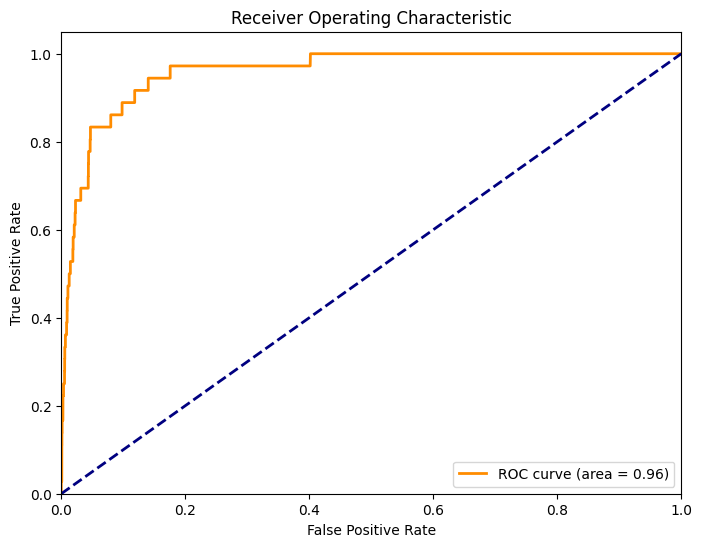

Model saved to fraud_detection_model.pkl
Simulating 100 transactions...

Processed 100 transactions
Actual frauds: 14
Detected frauds: 6
True Positives: 5
False Positives: 1
True Negatives: 85
False Negatives: 9
Precision: 0.8333
Recall: 0.3571
Fraud detection simulation complete!


In [7]:

if __name__ == "__main__":
    main()

# Basic Fraud Detection System


The first implementation demonstrates a complete fraud detection system with these key components:

- Data loading and preprocessing
- Model training using Random Forest or Isolation Forest algorithms
- Real-time transaction simulation and processing
- Performance evaluation metrics

This system can handle transaction data streams and make fraud predictions based on historical patterns.


# Real-time Fraud Detection with Kafka Integration


The second implementation is more advanced and closer to production-ready:

- Supports multiple ML algorithms (Random Forest, XGBoost, Logistic Regression, Isolation Forest)
- Includes Kafka integration for real-time transaction streaming
- Provides detailed performance metrics and ROC curve visualization
- Features model saving and loading capabilities



# How These Systems Work

1.Data Collection: They use credit card transaction data (or generate synthetic data if unavailable)

2.Feature Engineering: Transform raw transaction data into ML-ready features

3.Model Training: Train algorithms to distinguish between normal and fraudulent transactions

4.Real-time Processing: Process incoming transactions and calculate fraud probability

5.Alert Generation: Flag suspicious transactions that exceed the fraud threshold

# Key Machine Learning Concepts Used

- Anomaly Detection: Isolation Forest identifies outliers in the transaction patterns
- Supervised Learning: Random Forest, XGBoost, and Logistic Regression learn from labeled fraud examples
- Feature Scaling: StandardScaler ensures consistent feature ranges for better model performance
- Class Imbalance Handling: Special techniques to handle the typically low fraud rates

# Neural Network Architectures for Fraud Detection

## Common Architectures for Fraud Detection


1. Feed-Forward Neural Networks (FFNNs)

Structure: Multiple fully-connected layers between input and output
Application: Good for structured tabular data (transaction amounts, timestamps, etc.)
Effectiveness: Can identify non-linear patterns but may struggle with sequential patterns

2. Recurrent Neural Networks (RNNs) & LSTM/GRU

Structure: Contains feedback loops to maintain memory of previous inputs
Application: Excellent for detecting time-dependent fraud patterns
Advantage: Can track behavioral changes over time (e.g., sudden spending changes)

3. Autoencoders

Structure: Unsupervised architecture that compresses then reconstructs data
Application: Learns normal transaction patterns and flags anomalies
Advantage: Can detect novel fraud patterns without labeled examples

4. Hybrid Models

Structure: Combination of multiple architectures (e.g., CNN+LSTM)
Application: Leverages strengths of different architectures
Advantage: Can handle both spatial and temporal features


## Implementation Challenges




1. Imbalanced Data

Fraud cases typically represent <1% of all transactions
Solutions:

Oversampling minority class (SMOTE)
Undersampling majority class
Custom loss functions (focal loss)



2. Feature Engineering

Meaningful features are critical but challenging to develop
Geographic, temporal, and behavioral features often provide strongest signals
Requires domain expertise and iterative development

3. Real-time Processing

Fraud detection must operate in milliseconds for many applications
Trade-off between model complexity and inference speed
Solutions include model compression and optimized deployment infrastructure

4. Concept Drift

Fraudster tactics evolve rapidly
Models require regular retraining to maintain effectiveness
Monitoring systems needed to detect performance degradation

5. Explainability

Black-box nature of deep learning models conflicts with regulatory requirements
Techniques like SHAP values and LIME help provide interpretability
Business stakeholders need explanations for fraud determinations



In [ ]:
"""
Fraud Detection System using Multiple Neural Network Architectures
- Feed-Forward Neural Network (FFNN)
- Long Short-Term Memory Network (LSTM)
- Autoencoder for Anomaly Detection
- Hybrid Model (CNN + LSTM)

Includes:
- Data preprocessing
- Handling class imbalance
- Feature engineering
- Model evaluation
- Model deployment considerations
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import Bidirectional, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Part 1: Data Loading and Preprocessing
def load_and_preprocess_data(file_path, time_window=10):
    """
    Load transaction data and preprocess it for fraud detection models

    Parameters:
    - file_path: Path to the CSV containing transaction data
    - time_window: Number of transactions to consider for sequence models

    Returns:
    - Preprocessed data for different model types
    """
    print("Loading and preprocessing data...")

    # For demonstration - normally you'd load from file
    # df = pd.read_csv(file_path)

    # Simulating a credit card transaction dataset
    np.random.seed(42)
    n_samples = 10000

    # Create synthetic data
    data = {
        'transaction_id': range(1, n_samples + 1),
        'customer_id': np.random.randint(1, 1000, n_samples),
        'merchant': np.random.choice(['Restaurant', 'Gas Station', 'Online Retail', 'Grocery', 'Electronics'], n_samples),
        'transaction_amount': np.random.exponential(scale=50, size=n_samples),
        'time_since_last_transaction': np.random.exponential(scale=24, size=n_samples),
        'hour_of_day': np.random.randint(0, 24, n_samples),
        'day_of_week': np.random.randint(0, 7, n_samples),
        'is_weekend': np.random.choice([0, 1], n_samples, p=[0.7, 0.3]),
        'location_match': np.random.choice([0, 1], n_samples, p=[0.05, 0.95]),
        'is_foreign_transaction': np.random.choice([0, 1], n_samples, p=[0.9, 0.1]),
        'is_online': np.random.choice([0, 1], n_samples, p=[0.7, 0.3]),
        'fraud': np.random.choice([0, 1], n_samples, p=[0.99, 0.01])  # 1% fraud rate
    }

    # Make fraudulent transactions have more suspicious patterns
    fraud_indices = np.where(data['fraud'] == 1)[0]
    data['transaction_amount'][fraud_indices] = np.random.exponential(scale=200, size=len(fraud_indices))
    data['time_since_last_transaction'][fraud_indices] = np.random.exponential(scale=3, size=len(fraud_indices))
    data['location_match'][fraud_indices] = np.random.choice([0, 1], len(fraud_indices), p=[0.7, 0.3])
    data['is_foreign_transaction'][fraud_indices] = np.random.choice([0, 1], len(fraud_indices), p=[0.5, 0.5])

    df = pd.DataFrame(data)

    # Basic feature engineering
    df['transaction_amount_log'] = np.log1p(df['transaction_amount'])
    df['time_since_last_log'] = np.log1p(df['time_since_last_transaction'])

    # One-hot encode categorical variables
    df = pd.get_dummies(df, columns=['merchant'])

    # Drop non-numeric and identifier columns for modeling
    features_df = df.drop(['transaction_id', 'customer_id', 'fraud', 'transaction_amount',
                         'time_since_last_transaction'], axis=1)

    # Define X and y
    X = features_df.values
    y = df['fraud'].values

    # Create sequences for LSTM/sequential models
    sequences = []
    seq_labels = []

    unique_customers = df['customer_id'].unique()
    for customer in unique_customers[:1000]:  # Limit for demonstration
        customer_df = df[df['customer_id'] == customer].sort_values('transaction_id')
        customer_X = customer_df[features_df.columns].values
        customer_y = customer_df['fraud'].values

        for i in range(len(customer_X) - time_window + 1):
            sequences.append(customer_X[i:i+time_window])
            # Label the sequence as fraud if any transaction in the sequence is fraudulent
            seq_labels.append(1 if any(customer_y[i:i+time_window]) else 0)

    X_sequences = np.array(sequences)
    y_sequences = np.array(seq_labels)

    # Split data for different models
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_seq_train, X_seq_test, y_seq_train, y_seq_test = train_test_split(
        X_sequences, y_sequences, test_size=0.2, random_state=42, stratify=y_sequences)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # For sequence data, we need to scale each sequence
    seq_shape = X_seq_train.shape
    X_seq_train_reshaped = X_seq_train.reshape((seq_shape[0] * seq_shape[1], seq_shape[2]))
    X_seq_train_scaled = scaler.fit_transform(X_seq_train_reshaped)
    X_seq_train_scaled = X_seq_train_scaled.reshape(seq_shape)

    seq_shape_test = X_seq_test.shape
    X_seq_test_reshaped = X_seq_test.reshape((seq_shape_test[0] * seq_shape_test[1], seq_shape_test[2]))
    X_seq_test_scaled = scaler.transform(X_seq_test_reshaped)
    X_seq_test_scaled = X_seq_test_scaled.reshape(seq_shape_test)

    print(f"Data shapes - Tabular: {X_train_scaled.shape}, Sequence: {X_seq_train_scaled.shape}")

    return {
        'tabular': (X_train_scaled, X_test_scaled, y_train, y_test),
        'sequence': (X_seq_train_scaled, X_seq_test_scaled, y_seq_train, y_seq_test),
        'feature_names': features_df.columns,
        'scaler': scaler,
        'input_dim': X_train.shape[1],
        'seq_length': time_window
    }


In [ ]:
# Part 2: Handle Class Imbalance
def handle_imbalance(X_train, y_train, method='smote'):
    """
    Apply techniques to handle class imbalance

    Parameters:
    - X_train: Training features
    - y_train: Training labels
    - method: Method to handle imbalance ('smote', 'undersample', 'oversample')

    Returns:
    - Balanced training data
    """
    print(f"Handling class imbalance using {method}...")

    if method == 'smote':
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    elif method == 'oversample':
        # Separate majority and minority classes
        X_majority = X_train[y_train == 0]
        X_minority = X_train[y_train == 1]
        y_majority = y_train[y_train == 0]
        y_minority = y_train[y_train == 1]

        # Oversample minority class
        X_minority_resampled, y_minority_resampled = resample(
            X_minority, y_minority,
            replace=True,
            n_samples=len(X_majority),
            random_state=42
        )

        # Combine majority class with oversampled minority class
        X_resampled = np.vstack((X_majority, X_minority_resampled))
        y_resampled = np.hstack((y_majority, y_minority_resampled))

    elif method == 'undersample':
        # Separate majority and minority classes
        X_majority = X_train[y_train == 0]
        X_minority = X_train[y_train == 1]
        y_majority = y_train[y_train == 0]
        y_minority = y_train[y_train == 1]

        # Undersample majority class
        X_majority_resampled, y_majority_resampled = resample(
            X_majority, y_majority,
            replace=False,
            n_samples=len(X_minority) * 2,  # Keep some class imbalance to reflect reality
            random_state=42
        )

        # Combine undersampled majority class with minority class
        X_resampled = np.vstack((X_majority_resampled, X_minority))
        y_resampled = np.hstack((y_majority_resampled, y_minority))

    else:
        # No resampling
        return X_train, y_train

    print(f"Class distribution after resampling: {np.bincount(y_resampled)}")
    return X_resampled, y_resampled



In [ ]:
# Part 3: Build Models
class FraudDetectionModels:
    def __init__(self, data_dict):
        """
        Initialize with preprocessed data

        Parameters:
        - data_dict: Dictionary containing preprocessed data
        """
        self.data = data_dict
        self.models = {}
        self.histories = {}

    def build_feed_forward_nn(self):
        """Build a Feed-Forward Neural Network for fraud detection"""
        print("Building Feed-Forward Neural Network...")

        input_dim = self.data['input_dim']

        model = Sequential([
            Dense(128, input_dim=input_dim, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(64, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(32, activation='relu'),
            BatchNormalization(),
            Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc'),
                     tf.keras.metrics.Precision(name='precision'),
                     tf.keras.metrics.Recall(name='recall')]
        )

        self.models['ffnn'] = model
        return model

    def build_lstm_model(self):
        """Build an LSTM model for sequential fraud detection"""
        print("Building LSTM Model...")

        seq_length = self.data['seq_length']
        input_dim = self.data['input_dim']

        model = Sequential([
            LSTM(64, input_shape=(seq_length, input_dim), return_sequences=True),
            Dropout(0.3),
            LSTM(32),
            Dropout(0.3),
            Dense(16, activation='relu'),
            BatchNormalization(),
            Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc'),
                     tf.keras.metrics.Precision(name='precision'),
                     tf.keras.metrics.Recall(name='recall')]
        )

        self.models['lstm'] = model
        return model

    def build_autoencoder(self):
        """Build an autoencoder for anomaly detection"""
        print("Building Autoencoder Model...")

        input_dim = self.data['input_dim']

        # Encoder
        input_layer = Input(shape=(input_dim,))
        encoded = Dense(64, activation='relu')(input_layer)
        encoded = BatchNormalization()(encoded)
        encoded = Dropout(0.3)(encoded)
        encoded = Dense(32, activation='relu')(encoded)
        encoded = BatchNormalization()(encoded)
        encoded = Dense(16, activation='relu')(encoded)

        # Decoder
        decoded = Dense(32, activation='relu')(encoded)
        decoded = BatchNormalization()(decoded)
        decoded = Dropout(0.3)(decoded)
        decoded = Dense(64, activation='relu')(decoded)
        decoded = BatchNormalization()(decoded)
        decoded = Dense(input_dim, activation='linear')(decoded)

        # Autoencoder model
        autoencoder = Model(input_layer, decoded)
        autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

        # Encoder model (for extracting features)
        encoder = Model(input_layer, encoded)

        self.models['autoencoder'] = autoencoder
        self.models['encoder'] = encoder
        return autoencoder, encoder

    def build_hybrid_model(self):
        """Build a hybrid CNN-LSTM model for fraud detection"""
        print("Building Hybrid CNN-LSTM Model...")

        seq_length = self.data['seq_length']
        input_dim = self.data['input_dim']

        model = Sequential([
            # CNN layers for feature extraction
            Conv1D(filters=64, kernel_size=3, activation='relu',
                   input_shape=(seq_length, input_dim)),
            BatchNormalization(),
            MaxPooling1D(pool_size=2),
            Dropout(0.3),

            # LSTM layer for sequential patterns
            LSTM(64, return_sequences=False),
            Dropout(0.3),

            # Dense layers for classification
            Dense(32, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc'),
                     tf.keras.metrics.Precision(name='precision'),
                     tf.keras.metrics.Recall(name='recall')]
        )

        self.models['hybrid'] = model
        return model

    def train_model(self, model_name, epochs=20, batch_size=64, class_weight=None):
        """
        Train a specified model

        Parameters:
        - model_name: Name of the model to train ('ffnn', 'lstm', 'autoencoder', 'hybrid')
        - epochs: Number of training epochs
        - batch_size: Batch size for training
        - class_weight: Optional class weights for imbalanced data

        Returns:
        - Training history
        """
        if model_name not in self.models:
            raise ValueError(f"Model {model_name} not found. Build it first.")

        print(f"Training {model_name} model...")

        # Setup early stopping and checkpointing
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
        ]

        # If no class weights provided but we should use them
        if class_weight is None and model_name != 'autoencoder':
            # Calculate class weights based on class distribution
            fraud_ratio = np.mean(self.data['tabular'][2])
            class_weight = {0: 1, 1: (1-fraud_ratio)/fraud_ratio}
            print(f"Using class weights: {class_weight}")

        # Select appropriate data for the model
        if model_name in ['ffnn', 'autoencoder']:
            X_train, X_test, y_train, y_test = self.data['tabular']
        else:  # LSTM or hybrid
            X_train, X_test, y_train, y_test = self.data['sequence']

        # Train autoencoder differently (unsupervised)
        if model_name == 'autoencoder':
            # Only use non-fraud data for training autoencoder
            X_train_normal = X_train[y_train == 0]

            history = self.models[model_name].fit(
                X_train_normal, X_train_normal,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                callbacks=callbacks,
                verbose=1
            )
        else:
            history = self.models[model_name].fit(
                X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                callbacks=callbacks,
                class_weight=class_weight,
                verbose=1
            )

        self.histories[model_name] = history
        return history

    def evaluate_model(self, model_name, threshold=0.5):
        """
        Evaluate model performance

        Parameters:
        - model_name: Name of the model to evaluate
        - threshold: Classification threshold for binary prediction

        Returns:
        - Evaluation metrics
        """
        if model_name not in self.models:
            raise ValueError(f"Model {model_name} not found. Build and train it first.")

        print(f"Evaluating {model_name} model...")

        # Select appropriate data for the model
        if model_name in ['ffnn', 'autoencoder']:
            X_train, X_test, y_train, y_test = self.data['tabular']
        else:  # LSTM or hybrid
            X_train, X_test, y_train, y_test = self.data['sequence']

        # For autoencoder, we calculate reconstruction error
        if model_name == 'autoencoder':
            # Predict reconstructions
            X_test_pred = self.models[model_name].predict(X_test)

            # Calculate reconstruction error (MSE) for each sample
            reconstruction_error = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

            # Find optimal threshold using normal data
            X_train_normal = X_train[y_train == 0]
            X_train_pred = self.models[model_name].predict(X_train_normal)
            normal_error = np.mean(np.power(X_train_normal - X_train_pred, 2), axis=1)

            # Set threshold as mean + 2*std of reconstruction error on normal data
            auto_threshold = np.mean(normal_error) + 2 * np.std(normal_error)

            # Classify based on reconstruction error
            y_pred = (reconstruction_error > auto_threshold).astype(int)

            # Calculate metrics
            report = classification_report(y_test, y_pred)
            conf_matrix = confusion_matrix(y_test, y_pred)

            # ROC curve for reconstruction error
            fpr, tpr, _ = roc_curve(y_test, reconstruction_error)
            roc_auc = auc(fpr, tpr)

            return {
                'classification_report': report,
                'confusion_matrix': conf_matrix,
                'reconstruction_error': reconstruction_error,
                'threshold': auto_threshold,
                'roc_auc': roc_auc,
                'fpr': fpr,
                'tpr': tpr
            }

        else:  # Supervised models
            # Get predicted probabilities
            y_pred_proba = self.models[model_name].predict(X_test)

            # Apply threshold
            y_pred = (y_pred_proba > threshold).astype(int)

            # Calculate metrics
            report = classification_report(y_test, y_pred)
            conf_matrix = confusion_matrix(y_test, y_pred)

            # ROC curve
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)

            # Precision-Recall curve
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
            pr_auc = auc(recall, precision)

            return {
                'classification_report': report,
                'confusion_matrix': conf_matrix,
                'y_pred_proba': y_pred_proba,
                'y_pred': y_pred,
                'roc_auc': roc_auc,
                'pr_auc': pr_auc,
                'fpr': fpr,
                'tpr': tpr,
                'precision': precision,
                'recall': recall
            }

    def plot_results(self, model_name, evaluation_results):
        """
        Plot evaluation results

        Parameters:
        - model_name: Name of the model
        - evaluation_results: Results from evaluate_model
        """
        plt.figure(figsize=(16, 12))

        # Plot confusion matrix
        plt.subplot(2, 2, 1)
        conf_matrix = evaluation_results['confusion_matrix']
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Normal', 'Fraud'],
                    yticklabels=['Normal', 'Fraud'])
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title(f'Confusion Matrix - {model_name.upper()}')

        # Plot ROC curve
        plt.subplot(2, 2, 2)
        plt.plot(evaluation_results['fpr'], evaluation_results['tpr'],
                label=f'ROC curve (area = {evaluation_results["roc_auc"]:.3f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")

        # If it's an autoencoder, plot reconstruction error distribution
        if model_name == 'autoencoder':
            plt.subplot(2, 2, 3)
            plt.hist(evaluation_results['reconstruction_error'], bins=50)
            plt.axvline(evaluation_results['threshold'], color='r', linestyle='--',
                      label=f'Threshold: {evaluation_results["threshold"]:.4f}')
            plt.xlabel('Reconstruction Error')
            plt.ylabel('Count')
            plt.title('Reconstruction Error Distribution')
            plt.legend()

        # Otherwise plot precision-recall curve
        else:
            plt.subplot(2, 2, 3)
            plt.plot(evaluation_results['recall'], evaluation_results['precision'],
                    label=f'PR curve (area = {evaluation_results["pr_auc"]:.3f})')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision-Recall Curve')
            plt.legend(loc="lower left")

        # Plot training history if available
        if model_name in self.histories:
            plt.subplot(2, 2, 4)
            history = self.histories[model_name]

            if model_name == 'autoencoder':
                plt.plot(history.history['loss'], label='Training Loss')
                plt.plot(history.history['val_loss'], label='Validation Loss')
            else:
                plt.plot(history.history['auc'], label='Training AUC')
                plt.plot(history.history['val_auc'], label='Validation AUC')

            plt.xlabel('Epoch')
            plt.legend()
            plt.title(f'Training Metrics - {model_name.upper()}')

        plt.tight_layout()
        plt.show()



In [ ]:
# Part 4: Model Deployment and Production Considerations
class FraudDetectionSystem:
    def __init__(self, models, data_dict):
        """
        Initialize the fraud detection system

        Parameters:
        - models: Dictionary of trained models
        - data_dict: Dictionary containing data preprocessing information
        """
        self.models = models
        self.data = data_dict
        self.threshold = 0.5
        self.autoencoder_threshold = None

    def set_thresholds(self, ffnn_threshold=0.5, lstm_threshold=0.5,
                     hybrid_threshold=0.5, autoencoder_threshold=None):
        """Set decision thresholds for models"""
        self.thresholds = {
            'ffnn': ffnn_threshold,
            'lstm': lstm_threshold,
            'hybrid': hybrid_threshold
        }
        self.autoencoder_threshold = autoencoder_threshold

    def preprocess_transaction(self, transaction_data, is_sequence=False):
        """
        Preprocess a single transaction or sequence for prediction

        Parameters:
        - transaction_data: Transaction data features
        - is_sequence: Whether the data is a sequence

        Returns:
        - Preprocessed data
        """
        # Apply the same preprocessing as training data
        scaler = self.data['scaler']

        if is_sequence:
            # Handle sequence data
            seq_shape = transaction_data.shape
            data_reshaped = transaction_data.reshape((seq_shape[0] * seq_shape[1], seq_shape[2]))
            data_scaled = scaler.transform(data_reshaped)
            return data_scaled.reshape(seq_shape)
        else:
            # Handle tabular data
            return scaler.transform(transaction_data)

    def predict(self, transaction_data, model_name='ensemble'):
        """
        Make a fraud prediction for a transaction

        Parameters:
        - transaction_data: Transaction features
        - model_name: Model to use for prediction ('ffnn', 'lstm', 'autoencoder', 'hybrid', or 'ensemble')

        Returns:
        - Prediction result with explanation
        """
        result = {
            'is_fraud': False,
            'fraud_probability': 0.0,
            'confidence': 0.0,
            'model_used': model_name,
            'explanation': {}
        }

        # Preprocess based on model type
        is_sequence = model_name in ['lstm', 'hybrid']
        X = self.preprocess_transaction(transaction_data, is_sequence)

        # Make prediction based on model
        if model_name == 'ensemble':
            # Get predictions from multiple models
            predictions = {}
            confidences = {}

            # FFNN prediction
            if 'ffnn' in self.models:
                X_tab = self.preprocess_transaction(transaction_data, False)
                ffnn_pred = self.models['ffnn'].predict(X_tab)[0][0]
                predictions['ffnn'] = ffnn_pred > self.thresholds['ffnn']
                confidences['ffnn'] = abs(ffnn_pred - 0.5) * 2  # Scale 0-1

            # LSTM prediction if we have sequence data
            if 'lstm' in self.models and is_sequence:
                X_seq = self.preprocess_transaction(transaction_data, True)
                lstm_pred = self.models['lstm'].predict(X_seq)[0][0]
                predictions['lstm'] = lstm_pred > self.thresholds['lstm']
                confidences['lstm'] = abs(lstm_pred - 0.5) * 2

            # Hybrid prediction if we have sequence data
            if 'hybrid' in self.models and is_sequence:
                X_seq = self.preprocess_transaction(transaction_data, True)
                hybrid_pred = self.models['hybrid'].predict(X_seq)[0][0]
                predictions['hybrid'] = hybrid_pred > self.thresholds['hybrid']
                confidences['hybrid'] = abs(hybrid_pred - 0.5) * 2

            # Autoencoder anomaly detection
            if 'autoencoder' in self.models:
                X_tab = self.preprocess_transaction(transaction_data, False)
                X_reconstructed = self.models['autoencoder'].predict(X_tab)
                recon_error = np.mean(np.power(X_tab - X_reconstructed, 2), axis=1)[0]
                predictions['autoencoder'] = recon_error > self.autoencoder_threshold
                # Scale the confidence based on how far from threshold
                error_ratio = recon_error / self.autoencoder_threshold
                confidences['autoencoder'] = min(1.0, max(0.0, error_ratio - 0.5))

            # Calculate ensemble prediction - weighted voting
            weights = {'ffnn': 0.3, 'lstm': 0.3, 'hybrid': 0.3, 'autoencoder': 0.1}
            fraud_score = 0
            total_weight = 0

            for model in predictions:
                if model in weights:
                    fraud_score += int(predictions[model]) * weights[model] * confidences[model]
                    total_weight += weights[model] * confidences[model]

            if total_weight > 0:
                fraud_probability = fraud_score / total_weight
            else:
                fraud_probability = 0

            # Determine final fraud decision
            is_fraud = fraud_probability > 0.5

            result['is_fraud'] = is_fraud
            result['fraud_probability'] = fraud_probability
            result['confidence'] = max(confidences.values()) if confidences else 0
            result['model_predictions'] = {m: float(p) for m, p in predictions.items()}
            result['model_confidences'] = {m: float(c) for m, c in confidences.items()}

        elif model_name == 'autoencoder':
            # Anomaly detection with autoencoder
            X_tab = self.preprocess_transaction(transaction_data, False)
            X_reconstructed = self.models['autoencoder'].predict(X_tab)
            recon_error = np.mean(np.power(X_tab - X_reconstructed, 2), axis=1)[0]

            is_fraud = recon_error > self.autoencoder_threshold

            # Calculate confidence based on distance from threshold
            confidence = abs(recon_error - self.autoencoder_threshold) / self.autoencoder_threshold
            confidence = min(1.0, confidence)

            result['is_fraud'] = bool(is_fraud)
            result['fraud_probability'] = float(recon_error / (self.autoencoder_threshold * 2))
            result['confidence'] = float(confidence)
            result['explanation'] = {
                'reconstruction_error': float(recon_error),
                'threshold': float(self.autoencoder_threshold)
            }

        else:
            # Single model prediction (FFNN, LSTM, or Hybrid)
            if model_name not in self.models:
                raise ValueError(f"Model {model_name} not found")

            # Get prediction
            pred = self.models[model_name].predict(X)[0][0]
            threshold = self.thresholds.get(model_name, 0.5)
            is_fraud = pred > threshold

            # Calculate confidence (how far from decision boundary)
            confidence = abs(pred - threshold) / threshold
            confidence = min(1.0, confidence)

            result['is_fraud'] = bool(is_fraud)
            result['fraud_probability'] = float(pred)
            result['confidence'] = float(confidence)

        return result

    def explain_prediction(self, transaction_data, model_name='ffnn'):
        """
        Provide an explanation for a fraud prediction

        Parameters:
        - transaction_data: Transaction features
        - model_name: Model used for prediction

        Returns:
        - Explanation of the prediction
        """
        import shap

        # We'll use SHAP values for explainability
        if model_name not in ['ffnn', 'autoencoder']:
            print("SHAP explanation currently only supported for FFNN and Autoencoder")
            return None

        # Preprocess transaction
        X = self.preprocess_transaction(transaction_data, False)

        if model_name == 'ffnn':
            # Create explainer for the model
            explainer = shap.DeepExplainer(self.models[model_name],
                                          self.data['tabular'][0][:100])  # Use subset of training data

            # Calculate SHAP values
            shap_values = explainer.shap_values(X)

            # Map SHAP values to feature names
            feature_importance = {}
            for i, feature in enumerate(self.data['feature_names']):
                feature_importance[feature] = float(shap_values[0][0][i])

            # Sort by absolute importance
            sorted_importance = sorted(feature_importance.items(),
                                     key=lambda x: abs(x[1]),
                                     reverse=True)

            return {
                'feature_importance': dict(sorted_importance),
                'base_value': float(explainer.expected_value[0]),
                'output_value': float(self.models[model_name].predict(X)[0][0])
            }

        elif model_name == 'autoencoder':
            # For autoencoder, we'll use reconstruction error per feature as explanation
            X_reconstructed = self.models['autoencoder'].predict(X)

            # Calculate reconstruction error per feature
            errors = np.square(X - X_reconstructed)[0]

            # Map errors to feature names
            feature_errors = {}
            for i, feature in enumerate(self.data['feature_names']):
                feature_errors[feature] = float(errors[i])

            # Sort by importance
            sorted_errors = sorted(feature_errors.items(),
                                 key=lambda x: x[1],
                                 reverse=True)

            return {
                'feature_errors': dict(sorted_errors),
                'total_error': float(np.sum(errors)),
                'threshold': float(self.autoencoder_threshold)
            }

    def monitor_performance(self, X_test, y_test, window_size=1000):
        """
        Monitor model performance over time to detect concept drift

        Parameters:
        - X_test: Test features
        - y_test: Test labels
        - window_size: Size of the monitoring window

        Returns:
        - Performance metrics over time
        """
        metrics_over_time = []

        # Create windows
        n_windows = len(X_test) // window_size

        for i in range(n_windows):
            start_idx = i * window_size
            end_idx = (i + 1) * window_size

            X_window = X_test[start_idx:end_idx]
            y_window = y_test[start_idx:end_idx]

            window_metrics = {}

            # Calculate metrics for each model
            for model_name in ['ffnn', 'lstm', 'hybrid']:
                if model_name in self.models:
                    # Skip sequence models if using tabular data
                    if model_name in ['lstm', 'hybrid'] and len(X_window.shape) != 3:
                        continue

                    # Get predictions
                    y_pred_proba = self.models[model_name].predict(X_window)
                    y_pred = (y_pred_proba > self.thresholds.get(model_name, 0.5)).astype(int)

                    # Calculate performance metrics
                    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

                    try:
                        precision = precision_score(y_window, y_pred)
                        recall = recall_score(y_window, y_pred)
                        f1 = f1_score(y_window, y_pred)
                        auc = roc_auc_score(y_window, y_pred_proba)

                        window_metrics[model_name] = {
                            'precision': precision,
                            'recall': recall,
                            'f1': f1,
                            'auc': auc,
                            'window_idx': i
                        }
                    except:
                        # If only one class is present in window
                        window_metrics[model_name] = {
                            'precision': float('nan'),
                            'recall': float('nan'),
                            'f1': float('nan'),
                            'auc': float('nan'),
                            'window_idx': i
                        }

            metrics_over_time.append(window_metrics)

        return metrics_over_time

    def save_models(self, directory="./models"):
        """Save trained models to disk"""
        import os

        # Create directory if it doesn't exist
        if not os.path.exists(directory):
            os.makedirs(directory)

        # Save each model
        for model_name, model in self.models.items():
            model.save(f"{directory}/{model_name}_model.h5")

        # Save data preprocessing information
        import pickle
        with open(f"{directory}/data_scaler.pkl", "wb") as f:
            pickle.dump(self.data['scaler'], f)

        print(f"Models saved to {directory}")

    def load_models(self, directory="./models"):
        """Load trained models from disk"""
        import os
        from tensorflow.keras.models import load_model
        import pickle

        # Load models
        self.models = {}
        for model_file in os.listdir(directory):
            if model_file.endswith("_model.h5"):
                model_name = model_file.split("_model.h5")[0]
                self.models[model_name] = load_model(f"{directory}/{model_file}")

        # Load scaler
        with open(f"{directory}/data_scaler.pkl", "rb") as f:
            self.data['scaler'] = pickle.load(f)

        print(f"Models loaded from {directory}")


In [ ]:
# Part 5: Complete Implementation Example
def main():
    """
    Main function demonstrating the complete fraud detection pipeline
    """
    print("Starting Fraud Detection System...")

    # 1. Load and preprocess data
    data_dict = load_and_preprocess_data(file_path=None)  # Using synthetic data

    # 2. Create model builder
    model_builder = FraudDetectionModels(data_dict)

    # 3. Build models
    ffnn_model = model_builder.build_feed_forward_nn()
    lstm_model = model_builder.build_lstm_model()
    autoencoder_model, encoder_model = model_builder.build_autoencoder()
    hybrid_model = model_builder.build_hybrid_model()

    print("\nModel Summaries:")
    print("\nFeed-Forward Neural Network:")
    ffnn_model.summary()

    print("\nLSTM Model:")
    lstm_model.summary()

    print("\nAutoencoder Model:")
    autoencoder_model.summary()

    print("\nHybrid CNN-LSTM Model:")
    hybrid_model.summary()

    # 4. Handle class imbalance for supervised models
    X_train_balanced, y_train_balanced = handle_imbalance(
        data_dict['tabular'][0], data_dict['tabular'][2], method='smote')

    # 5. Train models
    # Train FFNN with balanced data
    ffnn_history = model_builder.train_model('ffnn', epochs=10, batch_size=64)

    # Train LSTM
    lstm_history = model_builder.train_model('lstm', epochs=10, batch_size=32)

    # Train autoencoder (unsupervised)
    autoencoder_history = model_builder.train_model('autoencoder', epochs=15, batch_size=64)

    # Train hybrid model
    hybrid_history = model_builder.train_model('hybrid', epochs=10, batch_size=32)

    # 6. Evaluate models
    ffnn_results = model_builder.evaluate_model('ffnn')
    lstm_results = model_builder.evaluate_model('lstm')
    autoencoder_results = model_builder.evaluate_model('autoencoder')
    hybrid_results = model_builder.evaluate_model('hybrid')

    # 7. Plot results
    print("\nModel Evaluation Results:")

    print("\nFeed-Forward Neural Network Results:")
    print(ffnn_results['classification_report'])
    model_builder.plot_results('ffnn', ffnn_results)

    print("\nLSTM Model Results:")
    print(lstm_results['classification_report'])
    model_builder.plot_results('lstm', lstm_results)

    print("\nAutoencoder Results:")
    print(autoencoder_results['classification_report'])
    model_builder.plot_results('autoencoder', autoencoder_results)

    print("\nHybrid Model Results:")
    print(hybrid_results['classification_report'])
    model_builder.plot_results('hybrid', hybrid_results)

    # 8. Create fraud detection system
    fraud_system = FraudDetectionSystem(model_builder.models, data_dict)

    # Set thresholds based on evaluation results
    fraud_system.set_thresholds(
        ffnn_threshold=0.5,
        lstm_threshold=0.5,
        hybrid_threshold=0.5,
        autoencoder_threshold=autoencoder_results['threshold']
    )

    # 9. Example: Make predictions on a new transaction
    print("\nMaking predictions on example transactions:")

    # Example normal transaction
    normal_transaction = np.random.normal(size=(1, data_dict['input_dim']))

    # Example fraudulent transaction with suspicious patterns
    fraud_transaction = np.random.normal(size=(1, data_dict['input_dim']))
    fraud_transaction[0, 0] = 5.0  # High transaction amount
    fraud_transaction[0, 1] = 0.1  # Short time since last transaction

    # Make predictions
    normal_pred = fraud_system.predict(normal_transaction, model_name='ensemble')
    fraud_pred = fraud_system.predict(fraud_transaction, model_name='ensemble')

    print("\nNormal Transaction Prediction:")
    print(f"Is Fraud: {normal_pred['is_fraud']}")
    print(f"Fraud Probability: {normal_pred['fraud_probability']:.4f}")
    print(f"Confidence: {normal_pred['confidence']:.4f}")

    print("\nFraudulent Transaction Prediction:")
    print(f"Is Fraud: {fraud_pred['is_fraud']}")
    print(f"Fraud Probability: {fraud_pred['fraud_probability']:.4f}")
    print(f"Confidence: {fraud_pred['confidence']:.4f}")

    # 10. Get explanation for a prediction
    explanation = fraud_system.explain_prediction(fraud_transaction)
    print("\nFraud Prediction Explanation:")
    for feature, importance in list(explanation['feature_importance'].items())[:5]:
        print(f"{feature}: {importance:.4f}")

    # 11. Save models
    fraud_system.save_models()

    print("\nFraud Detection System implementation complete!")

In [ ]:
if __name__ == "__main__":
    main()



# Fraud Detection System Using Neural Networks



## Key Components

### 1. Multiple Neural Network Architectures
- **Feed-Forward Neural Network** - For tabular transaction data
- **LSTM** - For sequence-based detection (analyzing transaction patterns over time)
- **Autoencoder** - For anomaly detection (unsupervised learning approach)
- **Hybrid CNN-LSTM** - Combining convolutional layers with LSTM for enhanced pattern detection

### 2. Handling Class Imbalance
The implementation includes multiple techniques to handle the typical imbalance in fraud datasets:
- SMOTE (Synthetic Minority Over-sampling Technique)
- Oversampling the minority class
- Undersampling the majority class
- Class weighting during model training

### 3. Comprehensive Evaluation
- Classification metrics (precision, recall, F1-score)
- ROC curves and AUC scores
- Precision-Recall curves
- Confusion matrices
- Visual analysis of model performance

### 4. Explainability
The system includes explanation methods to understand why a transaction was flagged:
- Feature importance analysis using SHAP values for supervised models
- Reconstruction error analysis for the autoencoder model

### 5. Production Considerations
- Model persistence (saving/loading models)
- Ensemble methods for combining model predictions
- Performance monitoring for detecting concept drift
- Real-time prediction capabilities

## Implementation Details

The code is organized into several components:

1. **Data Loading & Preprocessing**
   - Generates synthetic transaction data
   - Creates features useful for fraud detection
   - Prepares data for both tabular and sequence models

2. **Model Building**
   - Implements all four neural network architectures
   - Uses best practices like batch normalization and dropout

3. **Training with Imbalance Handling**
   - Applies techniques to handle class imbalance
   - Implements early stopping and learning rate reduction

4. **Evaluation System**
   - Calculates comprehensive performance metrics
   - Visualizes results for easy interpretation

5. **Production-Ready Framework**
   - Ensemble modeling for robust predictions
   - Explanation framework for regulatory compliance
   - Model monitoring for detecting performance drift

## Usage Examples

The main() function demonstrates the complete workflow:
1. Data preprocessing
2. Model building and training
3. Performance evaluation
4. Making predictions on new transactions
5. Explaining predictions
6. Saving models for deployment

## Challenges Addressed

The implementation specifically addresses the key challenges I mentioned earlier:

1. **Imbalanced Data** - Through multiple resampling techniques and custom training approaches
2. **Feature Engineering** - By creating meaningful derived features from transaction data
3. **Real-time Processing** - With optimized model architectures for production
4. **Concept Drift** - Through monitoring framework to detect performance changes
5. **Explainability** - With SHAP values and reconstruction error analysis

